In [22]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.cluster import KMeans
import hdbscan
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pycaret.regression import *
from pycaret.classification import *
from pycaret.classification import setup
from sklearn.impute import SimpleImputer
import seaborn as sns

Loading and Reading the data

In [23]:
df_credit_risk_data =  pd.read_csv('/home/sihle/Kig_dataset/archive (1)/credit_risk_dataset.csv')
print("Shape of the our credit risk data", df_credit_risk_data.shape)
print("-----------------------------------------------------------------------------")
print("Columns of the credit risk data",df_credit_risk_data.columns)
print("-----------------------------------------------------------------------------")
print('data type of our data', df_credit_risk_data.dtypes)

Shape of the our credit risk data (32581, 11)
-----------------------------------------------------------------------------
Columns of the credit risk data Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_amnt', 'loan_int_rate',
       'loan_status', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')
-----------------------------------------------------------------------------
data type of our data person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


Get the numerical and catagorical columns

In [24]:
Catagorical_cred_data = [i for i in df_credit_risk_data.select_dtypes(include='object').columns]
numerical_cred_data = [i for i in df_credit_risk_data.select_dtypes(include='number').columns]
print('categorical columns in application data', Catagorical_cred_data)
print('----------------------------------------------------------------------------------------')
print('numerical columns in application data', numerical_cred_data)

categorical columns in application data ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
----------------------------------------------------------------------------------------
numerical columns in application data ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length']


Visualise the data, by first plotting the Categorical columns

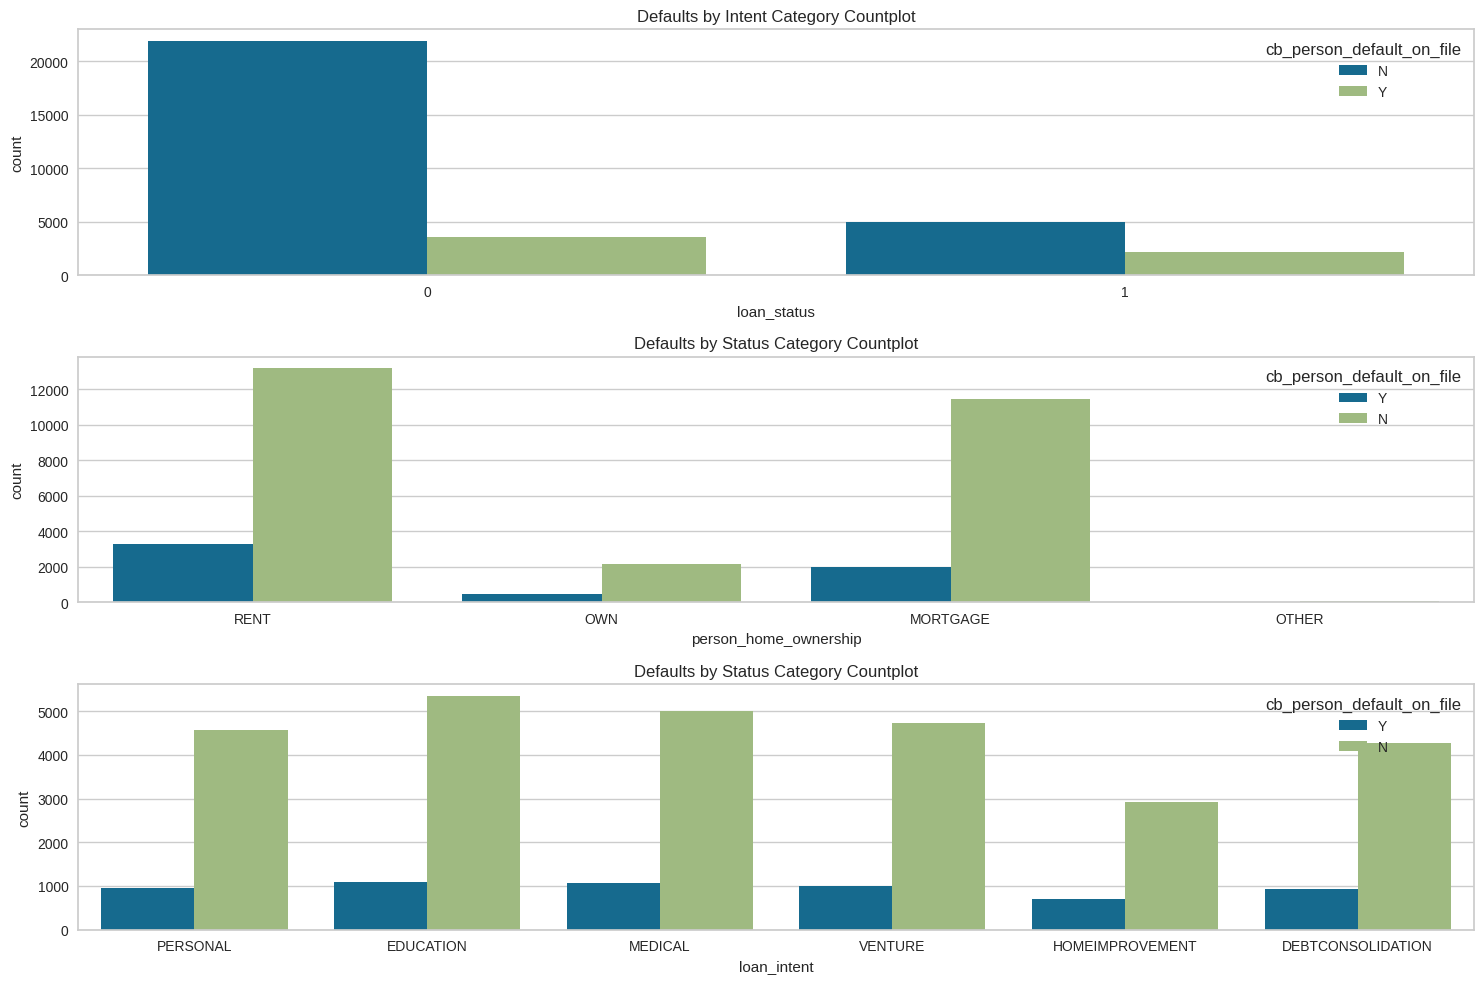

In [25]:
fig, axes = plt.subplots(3,1, figsize=(15,10))
df = df_credit_risk_data
sns.countplot(x=df["loan_status"], hue=df['cb_person_default_on_file'], ax=axes[0])
axes[0].set_title("Defaults by Intent Category Countplot")

sns.countplot(x=df["person_home_ownership"], hue=df['cb_person_default_on_file'], ax=axes[1])
axes[1].set_title("Defaults by Status Category Countplot")

sns.countplot(x=df["loan_intent"], hue=df['cb_person_default_on_file'], ax=axes[2])
axes[2].set_title("Defaults by Status Category Countplot")

plt.tight_layout()
plt.show()

Plotting all the numerical columns in our data

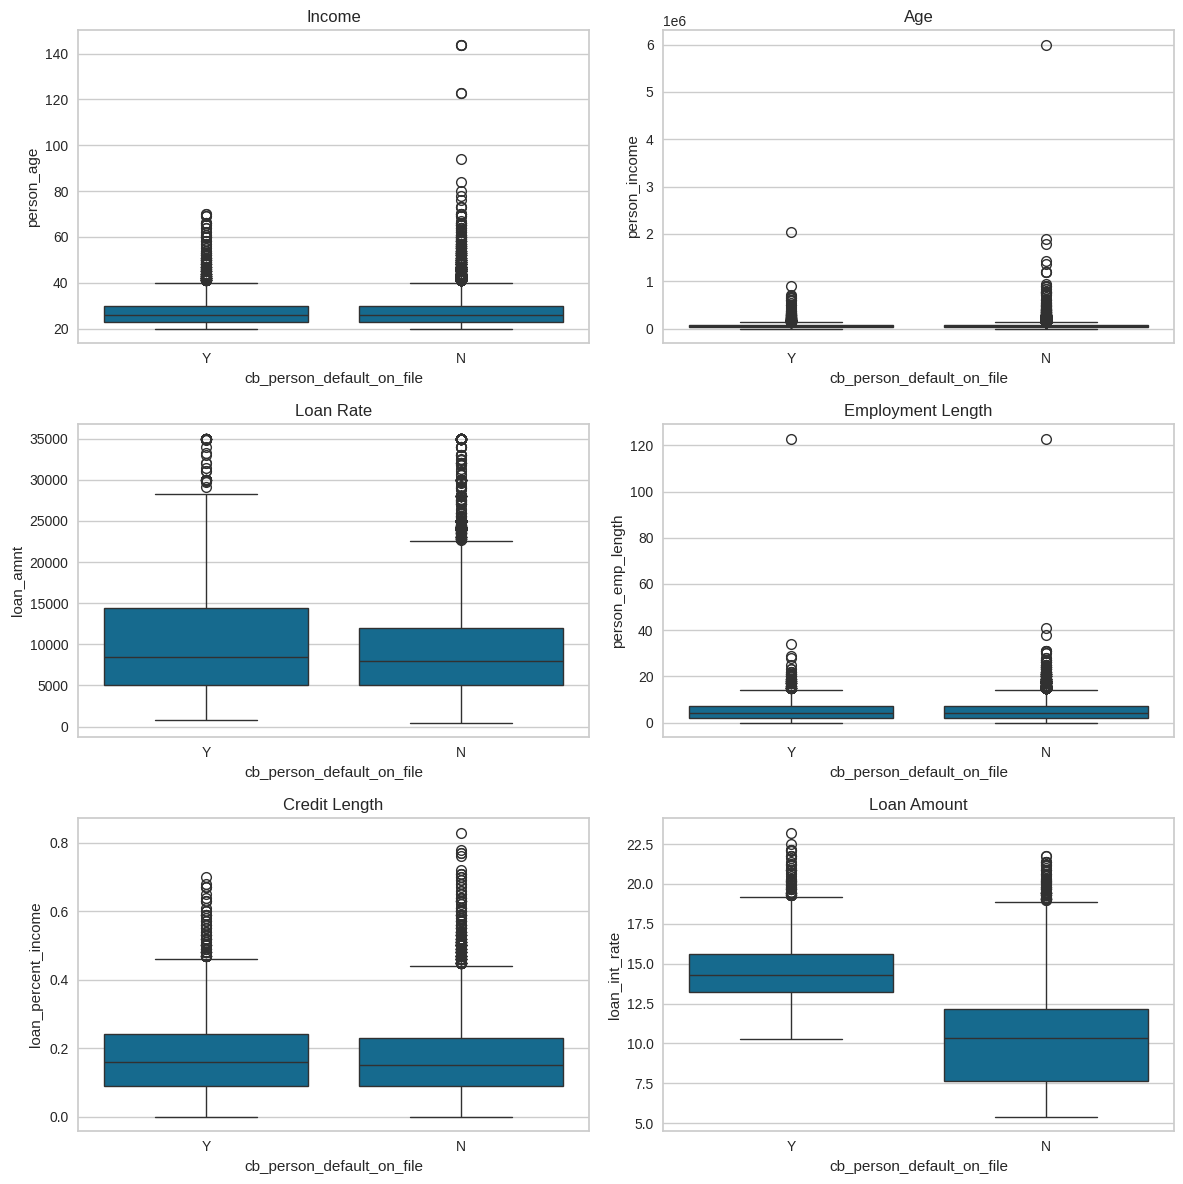

In [26]:
#Clean the data

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
sns.boxplot(data = df, x="cb_person_default_on_file", y="person_age", ax=axes[0,0])
axes[0,0].set_title("Income")
axes[0,0].ticklabel_format(style='plain', axis='y')

sns.boxplot(data = df, x="cb_person_default_on_file", y="person_income", ax=axes[0,1])
axes[0,1].set_title("Age")

sns.boxplot(data = df, x="cb_person_default_on_file", y="person_emp_length", ax=axes[1,1])
axes[1,1].set_title("Employment Length")

sns.boxplot(data = df, x="cb_person_default_on_file", y="loan_amnt", ax=axes[1,0])
axes[1,0].set_title("Loan Rate")

sns.boxplot(data = df, x="cb_person_default_on_file", y="loan_int_rate", ax=axes[2,1])
axes[2,1].set_title("Loan Amount")

sns.boxplot(data = df, x="cb_person_default_on_file", y="loan_percent_income", ax=axes[2,0])
axes[2,0].set_title("Credit Length")

plt.tight_layout()

In [27]:
# Calculate the mean values for the columns
mean_age = df.loc[df['person_age'] <= 100, 'person_age'].mean()
mean_emp_length = df.loc[df['person_emp_length'] <= 60, 'person_emp_length'].mean()

# Replace values greater than the thresholds with the mean values
df.loc[df['person_age'] > 100, 'person_age'] = mean_age
df.loc[df['person_emp_length'] > 60, 'person_emp_length'] = mean_emp_length

Transforming categorical variables

In [28]:
#Using get_dummies function
model_df=pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent'])
model_df['cb_person_default_on_file'] = [1 if i == "Y" else 0 for i in df['cb_person_default_on_file']]

Now Cleaning the data

In [29]:
#Check how many columns have missing values
model_df.isnull().sum()

person_age                           0
person_income                        0
person_emp_length                  895
loan_amnt                            0
loan_int_rate                     3116
loan_status                          0
loan_percent_income                  0
cb_person_default_on_file            0
cb_person_cred_hist_length           0
person_home_ownership_MORTGAGE       0
person_home_ownership_OTHER          0
person_home_ownership_OWN            0
person_home_ownership_RENT           0
loan_intent_DEBTCONSOLIDATION        0
loan_intent_EDUCATION                0
loan_intent_HOMEIMPROVEMENT          0
loan_intent_MEDICAL                  0
loan_intent_PERSONAL                 0
loan_intent_VENTURE                  0
dtype: int64

In [30]:
#We use SimpleImputer to fill in the missing values with mean, there are various other methods as well
columns_to_impute = ['person_emp_length', 'loan_int_rate']
imputer = SimpleImputer(strategy='mean')

#Fit and transform the imputer on the selected columns
model_df[columns_to_impute] = imputer.fit_transform(model_df[columns_to_impute])

In [31]:
#Check how many columns have missing values
model_df.isnull().sum()

person_age                        0
person_income                     0
person_emp_length                 0
loan_amnt                         0
loan_int_rate                     0
loan_status                       0
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0
person_home_ownership_MORTGAGE    0
person_home_ownership_OTHER       0
person_home_ownership_OWN         0
person_home_ownership_RENT        0
loan_intent_DEBTCONSOLIDATION     0
loan_intent_EDUCATION             0
loan_intent_HOMEIMPROVEMENT       0
loan_intent_MEDICAL               0
loan_intent_PERSONAL              0
loan_intent_VENTURE               0
dtype: int64

In [32]:
#There are no duplicates so no action needed here
model_df.duplicated().sum()

165

In [33]:
#Drop all duplicate rows and keep the first occurrence
df_no_duplicates = model_df.drop_duplicates(keep='first')

In [34]:
df_no_duplicates.duplicated().sum()

0

In [35]:
#Check if the data is imbalanced
df_no_duplicates.groupby('cb_person_default_on_file')['cb_person_default_on_file'].count()*100/len(df_no_duplicates['cb_person_default_on_file'])

cb_person_default_on_file
0    82.323544
1    17.676456
Name: cb_person_default_on_file, dtype: float64

Model Selection


In [36]:
# Assuming X is your feature matrix and y is your target vector
X = df_no_duplicates.drop(columns='cb_person_default_on_file')
y = df_no_duplicates['cb_person_default_on_file']

# Split the data
X_train, X_test, y_train, y_test = split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE, because our data is imbalanced
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the distribution after resampling
print("Original distribution:")
print(y_train.value_counts(normalize=True))
print("\nAfter SMOTE:")
print(y_train_smote.value_counts(normalize=True))


Original distribution:
0    0.823461
1    0.176539
Name: cb_person_default_on_file, dtype: float64

After SMOTE:
0    0.5
1    0.5
Name: cb_person_default_on_file, dtype: float64


In [37]:
reg_experiment = setup(df_no_duplicates, 
                       target = 'cb_person_default_on_file', 
                       session_id=42, 
                       experiment_name='credit_risk',
                       normalize = True, 
                       transformation = True, 
                       remove_multicollinearity = True, 
                       multicollinearity_threshold = 0.5
                           )

,Description,Value
0,Session id,42
1,Target,cb_person_default_on_file
2,Target type,Binary
3,Original data shape,"(32416, 19)"
4,Transformed data shape,"(32416, 17)"
5,Transformed train set shape,"(22691, 17)"
6,Transformed test set shape,"(9725, 17)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


In [38]:
best_model = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:30:56
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.8254,0.8480,0.2725,0.5082,0.3490,0.2612,0.2796,0.0330
ada,Ada Boost Classifier,0.8244,0.8846,0.4675,0.5051,0.4758,0.3730,0.3780,0.0780
lr,Logistic Regression,0.8242,0.8676,0.2830,0.5058,0.3626,0.2700,0.2855,0.1610
lda,Linear Discriminant Analysis,0.8231,0.8686,0.2663,0.5006,0.3474,0.2560,0.2732,0.0390
rf,Random Forest Classifier,0.8230,0.8780,0.3914,0.4990,0.4383,0.3351,0.3388,0.1730
ridge,Ridge Classifier,0.8226,0.8686,0.0845,0.4900,0.1440,0.0970,0.1453,0.0260
gbc,Gradient Boosting Classifier,0.8220,0.8868,0.4011,0.4977,0.4432,0.3389,0.3423,0.3080
xgboost,Extreme Gradient Boosting,0.8211,0.8807,0.4268,0.4934,0.4572,0.3509,0.3524,0.0600
et,Extra Trees Classifier,0.8205,0.8528,0.2989,0.4878,0.3705,0.2728,0.2841,0.1860
knn,K Neighbors Classifier,0.8161,0.7874,0.3022,0.4684,0.3672,0.2655,0.2743,0.1700


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
svm = create_model('svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8189,0.8145,0.1194,0.4571,0.1893,0.1252,0.1616
1,0.8405,0.8670,0.4115,0.5670,0.4769,0.3855,0.3924
2,0.8255,0.8482,0.2918,0.5109,0.3714,0.2788,0.2935
3,0.8193,0.8362,0.2693,0.4800,0.3450,0.2497,0.2638
4,0.8246,0.8492,0.1571,0.5122,0.2405,0.1717,0.2106
5,0.8193,0.8541,0.3117,0.4826,0.3788,0.2787,0.2879
6,0.8308,0.8593,0.2668,0.5431,0.3579,0.2732,0.2962
7,0.8264,0.8400,0.3242,0.5138,0.3976,0.3021,0.3131
8,0.8224,0.8520,0.2993,0.4959,0.3733,0.2771,0.2891


In [40]:
pred_holdouts = predict_model(svm)
pred_holdouts.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8241,0.5992,0.2513,0.5047,0.3355,0.2470,0.2671


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file,prediction_label
20625,32.0,70000,2.0,9850,7.750000,0,0.14,9,0,0,0,1,0,0,0,0,1,0,0,0
23861,31.0,113000,1.0,9600,14.910000,1,0.08,7,0,0,0,1,0,0,1,0,0,0,1,1
27438,29.0,108800,1.0,18500,17.799999,1,0.14,10,1,0,0,0,0,0,0,1,0,0,0,1
14906,22.0,48000,5.0,15000,11.890000,1,0.31,4,0,0,0,1,0,0,0,1,0,0,0,0
28333,28.0,53000,0.0,7000,9.880000,0,0.13,6,0,0,0,1,0,0,0,0,1,0,0,0


In [41]:
save_model(svm,'/home/sihle/Kig_dataset/archive_creditScoring (1)')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['person_age', 'person_income',
                                              'person_emp_length', 'loan_amnt',
                                              'loan_int_rate', 'loan_status',
                                              'loan_percent_income',
                                              'cb_person_cred_hist_length',
                                              'person_home_ownership_MORTGAGE',
                                              'person_home_ownership_OTHER',
                                              'person_home_ownership_OWN',
                                              'person_ho...
                 ('trained_model',
                  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                                early_stopping=False, epsilon=0.1, eta0=0.001,
    